# Genre Classification Task - Marc Jones

In this notebook I undertake the analysis, preprocessing, and classification of a music & speech sound collection separate by genre. I'll use [SciKit-Learn](http://scikit-learn.org/stable/index.html) & [Keras](https://keras.io) to prepare the data and build out two classifiers: a __support vector machine__ (SVM) and a simple __two-layer neural network__ (NN). 

In this notebook and accompanying command-line executable version of this program I have _pre-extracted_ (using [MTG's Essentia library](http://essentia.upf.edu/documentation/)) the features of all the songs provided in the dataset, including them as a .csv file named __"genre_df.csv"__. This file is essential to the notebook or command-line executable functioning properly. In a future update, I will include the code to download, unpack, and extract the audio feature data from the associated dataset.

In [11]:
# Imports
import os, itertools, sys, time, json, pandas, warnings, numpy as np, matplotlib.pyplot as plt
from IPython.display import SVG
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC, SVC
from utils import flatten_json_dicts, flatten_json_lists, remove_non_numerical_data

warnings.filterwarnings(action='ignore')
if not os.path.isfile('genre_df.csv'):
    sys.exit('ERROR: Cannot find the \'genre_df.csv\' file. The features from included audio must first be extracted.')
    
print('Imports successful')

Imports successful


## Data Organization
We'll use a _data frame_ object (from the [pandas library](https://pandas.pydata.org) to store all the feature files 
    (where __rows represent one song analyzed__ and __columns represent the individual features__. 
    In order for the data frame to accurately model a each feature vector, I've chosen to 
    flatten the dictionary/json read feature data such that there are no nested dictionaries 
    or lists of data. Each nested dictionary becomes its own dictionary key while each datapoint 
    found in a list also becomes its own dictionary key based on sequential ordering. This process 
    converts the individual json files into one combined data structure that closely resembles a 
    csv file, which we can then preview the first few elements in-line. 

In [2]:
# Organize Data
if os.path.isfile('genre_df.csv'):
    df = pandas.read_csv('genre_df.csv')
    # read_csv automatically adds row nums but they're already saved to file so we must remove the duplicates
    df = df.drop('Unnamed: 0',1)
else:
    # use a pandas dataframe to hold all the data
    df = pandas.DataFrame(flat, index=[0])
    # load and flatten json files then add them to our data frame
    for json_file in json_filepaths:
        data = json.load(open(json_file), strict=False)
        # add genre annotation to our data read from the json file
        data['genre'] = data['genre'][0]
        # remove the metadata field as we wont be using it for classification
        data.pop('metadata',None)
        # flatten the nested dictionaries features into one
        almostflat = flatten_json_dicts(data)
        # flatten the nested lists of features into sequential features 
        flat = flatten_json_lists(flatten_json_lists(almostflat)) # needs two runs for the mfcc covariance stats
        flat = remove_non_numerical_data(flat)
        df = df.append(flat,ignore_index=True)
    # remove all rhythm_beats_pos columns (varied sequential length = a lot of NaN values)
    # store altered data frame into new object 
    for col in df.columns:
        if col.startswith('rhythm_beats') and col.endswith('_position'):
            df = df.drop(col,1) 
    # save dataframe to csv 
    df.to_csv('genre_df.csv')
# unwated columns removed in line with 'Gaia' standard.
unwanted_columns = ['_dmean', '_dvar', '_min', '_max', 'cov', 'tonal.hpcp', 'lowlevel_silence_rate']
for col in df.columns:
    if any([unwanted in col for unwanted in unwanted_columns]):
        df = df.drop(col,1)
        
print('Data loaded into memory')

Data loaded into memory


## Data Preprocessing
Before classification the data must be standardized to reduce its overal range. This is accomplished using scikit's standard scalar method which __removes the mean, scales to unit variance__, ultimately transforming the data to appear of a Gaussian distribution. Further, the dimensionality of the data is reduced down to __5 components__ - a factor relative to the overall distribution of intra-class variance ( ~440 overall samples / ~80 samples per class = 5.5 ; thus 5 was chosen). For comparative purposes, dimensionality reduction is accomplished using __Principle Component Analysis__ (PDA) and __Linear Discriminate Analysis__ (LDA), PCA works towards identifying the maximum variance _within the data_ across 'n' number principle components, while LDA works towards identifying the maximum variance _between classes_ across 'n' number principle components. LDA is often explicitly used for multi-class supervised learning tasks such as this but I thought it'd be interesting to compare the performance of both

In [3]:
# Preprocess Data
# create feature vectors
classes = {'cla':0,'dan':1,'hip':2,'jaz':3,'pop':4,'rhy':5,'roc':6,'spe':7}
feature_vectors = df.drop('genre',1) # seperate the labels from the features
labels = df['genre'] # store labels seperately
labels = np.array([classes[i] for i in labels]) # convert to numeric values

# standardize feature values 
scaler = StandardScaler()
scaled_feature_vectors = scaler.fit_transform(feature_vectors)

# reduce data dimensionality w/ PCA (max data variation) & LDA (max interclass variation)
pca = PCA(n_components=5)
pca_reduced_feature_vectors = pca.fit(scaled_feature_vectors).transform(scaled_feature_vectors)

lda = LinearDiscriminantAnalysis(n_components=5)
lda_reduced_feature_vectors = lda.fit(scaled_feature_vectors, labels).transform(scaled_feature_vectors)

print('Data preprocessed using normalization then reduced with PCA and LDA')

Data preprocessed using normalization then reduced with PCA and LDA


## Plot (top-2) Dimensions of Reduced Data
Here we can see how PCA and LDA varies differently in their reductive capabilities. 

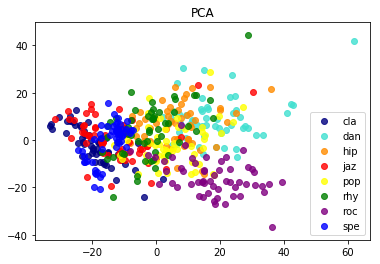

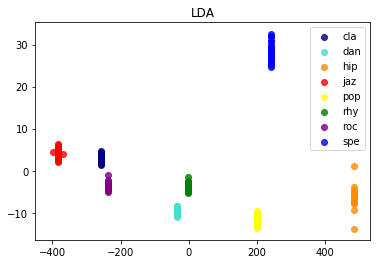

Displaying PCA and LDA reduced representations


In [4]:
colors = ['navy', 'turquoise', 'darkorange', 'red', 'yellow', 'green', 'purple', 'blue']

plt.figure()
plt.title('PCA')
for color, i, target_name in zip(colors, list(classes.values()), list(classes.keys())):
    plt.scatter(pca_reduced_feature_vectors[labels == i, 0], 
                pca_reduced_feature_vectors[labels == i, 1], 
                color=color, alpha=.8, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)


plt.figure()
plt.title('LDA')
for color, i, target_name in zip(colors, list(classes.values()), list(classes.keys())):
    plt.scatter(lda_reduced_feature_vectors[labels == i, 0], 
                lda_reduced_feature_vectors[labels == i, 1], 
                color=color, alpha=.8, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.show()
print('Displaying PCA and LDA reduced representations')

In [5]:
# Helper function to plot a nicer looking confusion. matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Purples):        
    # plot easy to read matrix  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted')

## Create Train and Test Data Subsets
One for classifying on the PCA reduced data and another for classifying on the LDA reduced data

In [6]:
# create test and training subsets of the PCA reduced data
pca_features_train, pca_features_test, pca_pred_train, pca_pred_test = train_test_split(
    pca_reduced_feature_vectors, labels, test_size=0.2)

# create test and training subsets of the LDA reduced data
lda_features_train, lda_features_test, lda_pred_train, lda_pred_test = train_test_split(
    lda_reduced_feature_vectors, labels, test_size=0.2)

## Classification: SVM with PCA


Correct Classified Instances: 0.6363636363636364

             precision    recall  f1-score   support

        cla       0.73      0.73      0.73        11
        dan       1.00      0.68      0.81        19
        hip       0.19      0.75      0.30         4
        jaz       0.50      0.67      0.57        12
        pop       0.54      0.58      0.56        12
        rhy       1.00      0.09      0.17        11
        roc       0.83      0.62      0.71         8
        spe       0.92      1.00      0.96        11

avg / total       0.77      0.64      0.64        88



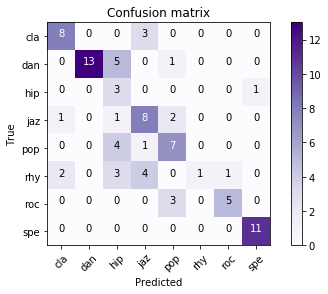

In [7]:
# SVM classification with PCA
# train the classifier
classifier = LinearSVC()
classifier.fit(pca_features_train, pca_pred_train)

cci = classifier.score(pca_features_test,pca_pred_test)
predictions = classifier.predict(pca_features_test)

print('\n'+'Correct Classified Instances:',cci)
conf_matrix = confusion_matrix(pca_pred_test,predictions)
plot_confusion_matrix(conf_matrix,classes)
class_report = classification_report(pca_pred_test,predictions,target_names=classes)
print('\n'+class_report)

## Classification: SVM with LDA


Correct Classified Instances: 0.7613636363636364

             precision    recall  f1-score   support

        cla       1.00      1.00      1.00        10
        dan       1.00      1.00      1.00        14
        hip       0.00      0.00      0.00        10
        jaz       1.00      1.00      1.00        13
        pop       0.00      0.00      0.00        11
        rhy       0.28      1.00      0.43         8
        roc       1.00      1.00      1.00        11
        spe       1.00      1.00      1.00        11

avg / total       0.70      0.76      0.71        88



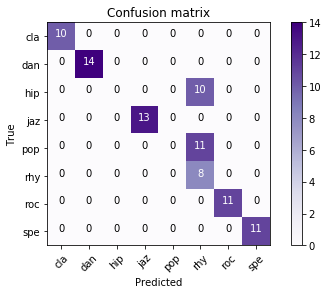

In [8]:
# SVM classification with LDA
# train the classifier
classifier = LinearSVC()
classifier.fit(lda_features_train, lda_pred_train)

cci = classifier.score(lda_features_test,lda_pred_test)
predictions = classifier.predict(lda_features_test)

print('\n'+'Correct Classified Instances:',cci)
conf_matrix = confusion_matrix(lda_pred_test,predictions)
plot_confusion_matrix(conf_matrix,classes)
class_report = classification_report(lda_pred_test,predictions,target_names=classes)
print('\n'+class_report)

## Classification: NN with PCA

Epoch 1/200
 - 0s - loss: 7.5708 - acc: 0.0883
Epoch 2/200
 - 0s - loss: 6.7333 - acc: 0.1026
Epoch 3/200
 - 0s - loss: 6.0501 - acc: 0.1197
Epoch 4/200
 - 0s - loss: 5.4085 - acc: 0.1254
Epoch 5/200
 - 0s - loss: 4.8184 - acc: 0.1510
Epoch 6/200
 - 0s - loss: 4.2846 - acc: 0.1766
Epoch 7/200
 - 0s - loss: 3.8295 - acc: 0.2194
Epoch 8/200
 - 0s - loss: 3.4313 - acc: 0.2507
Epoch 9/200
 - 0s - loss: 3.0787 - acc: 0.2877
Epoch 10/200
 - 0s - loss: 2.7654 - acc: 0.3305
Epoch 11/200
 - 0s - loss: 2.5031 - acc: 0.3447
Epoch 12/200
 - 0s - loss: 2.2679 - acc: 0.3618
Epoch 13/200
 - 0s - loss: 2.0678 - acc: 0.3932
Epoch 14/200
 - 0s - loss: 1.8968 - acc: 0.4188
Epoch 15/200
 - 0s - loss: 1.7446 - acc: 0.4359
Epoch 16/200
 - 0s - loss: 1.6188 - acc: 0.4444
Epoch 17/200
 - 0s - loss: 1.5148 - acc: 0.4729
Epoch 18/200
 - 0s - loss: 1.4188 - acc: 0.4815
Epoch 19/200
 - 0s - loss: 1.3383 - acc: 0.4900
Epoch 20/200
 - 0s - loss: 1.2696 - acc: 0.5299
Epoch 21/200
 - 0s - loss: 1.2073 - acc: 0.5584
E

Epoch 171/200
 - 0s - loss: 0.5194 - acc: 0.7607
Epoch 172/200
 - 0s - loss: 0.5204 - acc: 0.7607
Epoch 173/200
 - 0s - loss: 0.5178 - acc: 0.7607
Epoch 174/200
 - 0s - loss: 0.5159 - acc: 0.7607
Epoch 175/200
 - 0s - loss: 0.5149 - acc: 0.7550
Epoch 176/200
 - 0s - loss: 0.5152 - acc: 0.7721
Epoch 177/200
 - 0s - loss: 0.5152 - acc: 0.7607
Epoch 178/200
 - 0s - loss: 0.5154 - acc: 0.7692
Epoch 179/200
 - 0s - loss: 0.5141 - acc: 0.7607
Epoch 180/200
 - 0s - loss: 0.5136 - acc: 0.7664
Epoch 181/200
 - 0s - loss: 0.5122 - acc: 0.7749
Epoch 182/200
 - 0s - loss: 0.5159 - acc: 0.7721
Epoch 183/200
 - 0s - loss: 0.5101 - acc: 0.7664
Epoch 184/200
 - 0s - loss: 0.5103 - acc: 0.7749
Epoch 185/200
 - 0s - loss: 0.5080 - acc: 0.7664
Epoch 186/200
 - 0s - loss: 0.5078 - acc: 0.7749
Epoch 187/200
 - 0s - loss: 0.5087 - acc: 0.7664
Epoch 188/200
 - 0s - loss: 0.5082 - acc: 0.7635
Epoch 189/200
 - 0s - loss: 0.5063 - acc: 0.7749
Epoch 190/200
 - 0s - loss: 0.5080 - acc: 0.7692
Epoch 191/200
 - 0s 

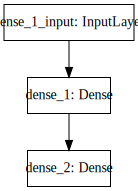

In [9]:
# NN classification with PCA
# simple multi-layer perceptron architecture with 16 hidden units
model = Sequential()
model.add(Dense(16, activation='relu', input_dim=5))
model.add(Dense(8, activation='softmax'))

# configure the model for training
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# one-hot encoding
onehot_labels = to_categorical(pca_pred_train, num_classes=None)
onehot_pca_pred_test = to_categorical(pca_pred_test, num_classes=None)

model.fit(pca_features_train, onehot_labels, epochs=200, batch_size=None, verbose=2)

scores = model.evaluate(x=pca_features_test, y=onehot_pca_pred_test, batch_size=None, verbose=1, sample_weight=None, steps=None)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


conf_matrix = confusion_matrix(pca_pred_test,predictions)
plot_confusion_matrix(conf_matrix,classes)

# prints model to notebook
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Classification: NN with LDA

Epoch 1/200
 - 0s - loss: 10.7427 - acc: 0.1510
Epoch 2/200
 - 0s - loss: 10.5591 - acc: 0.2279
Epoch 3/200
 - 0s - loss: 10.4895 - acc: 0.2393
Epoch 4/200
 - 0s - loss: 8.9399 - acc: 0.3248
Epoch 5/200
 - 0s - loss: 8.3196 - acc: 0.3704
Epoch 6/200
 - 0s - loss: 8.2744 - acc: 0.3704
Epoch 7/200
 - 0s - loss: 8.2348 - acc: 0.3818
Epoch 8/200
 - 0s - loss: 8.1973 - acc: 0.4046
Epoch 9/200
 - 0s - loss: 8.1621 - acc: 0.4530
Epoch 10/200
 - 0s - loss: 8.1293 - acc: 0.4872
Epoch 11/200
 - 0s - loss: 8.1004 - acc: 0.5043
Epoch 12/200
 - 0s - loss: 8.0759 - acc: 0.5043
Epoch 13/200
 - 0s - loss: 8.0556 - acc: 0.5043
Epoch 14/200
 - 0s - loss: 8.0401 - acc: 0.5043
Epoch 15/200
 - 0s - loss: 8.0282 - acc: 0.5043
Epoch 16/200
 - 0s - loss: 8.0188 - acc: 0.5043
Epoch 17/200
 - 0s - loss: 8.0120 - acc: 0.5043
Epoch 18/200
 - 0s - loss: 8.0069 - acc: 0.5043
Epoch 19/200
 - 0s - loss: 8.0029 - acc: 0.5043
Epoch 20/200
 - 0s - loss: 7.9998 - acc: 0.5043
Epoch 21/200
 - 0s - loss: 7.9974 - acc: 0.504

Epoch 171/200
 - 0s - loss: 7.9902 - acc: 0.5043
Epoch 172/200
 - 0s - loss: 7.9902 - acc: 0.5043
Epoch 173/200
 - 0s - loss: 7.9902 - acc: 0.5043
Epoch 174/200
 - 0s - loss: 7.9902 - acc: 0.5043
Epoch 175/200
 - 0s - loss: 7.9902 - acc: 0.5043
Epoch 176/200
 - 0s - loss: 7.9902 - acc: 0.5043
Epoch 177/200
 - 0s - loss: 7.9902 - acc: 0.5043
Epoch 178/200
 - 0s - loss: 7.9902 - acc: 0.5043
Epoch 179/200
 - 0s - loss: 7.9902 - acc: 0.5043
Epoch 180/200
 - 0s - loss: 7.9902 - acc: 0.5043
Epoch 181/200
 - 0s - loss: 7.9902 - acc: 0.5043
Epoch 182/200
 - 0s - loss: 7.9902 - acc: 0.5043
Epoch 183/200
 - 0s - loss: 7.9902 - acc: 0.5043
Epoch 184/200
 - 0s - loss: 7.9902 - acc: 0.5043
Epoch 185/200
 - 0s - loss: 7.9902 - acc: 0.5043
Epoch 186/200
 - 0s - loss: 7.9902 - acc: 0.5043
Epoch 187/200
 - 0s - loss: 7.9902 - acc: 0.5043
Epoch 188/200
 - 0s - loss: 7.9902 - acc: 0.5043
Epoch 189/200
 - 0s - loss: 7.9902 - acc: 0.5043
Epoch 190/200
 - 0s - loss: 7.9902 - acc: 0.5043
Epoch 191/200
 - 0s 

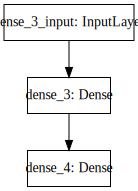

In [10]:
# NN classification with LDA    
# simple multi-layer perceptron architecture with 16 hidden units
model = Sequential()
model.add(Dense(16, activation='relu', input_dim=5))
model.add(Dense(8, activation='softmax'))

# configure the model for training
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# one-hot encoding
onehot_labels = to_categorical(lda_pred_train, num_classes=None)
onehot_lda_pred_test = to_categorical(lda_pred_test, num_classes=None)

model.fit(lda_features_train, onehot_labels, epochs=200, batch_size=None, verbose=2)

scores = model.evaluate(x=lda_features_test, y=onehot_lda_pred_test, batch_size=None, verbose=1, sample_weight=None, steps=None)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# prints model to notebook
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Results & Discussion

Interestingly LDA served as the better data dimensionality reduction tool for the support vector machine, while PCA seemed to aid the neural network in minimizing its loss over the provided 200 epochs. When the neural net was presented with LDA reduced data it plateus quickly during gradient descent, likely at a local optima, failing to reach the global optimum value for loss reduction. Further implementing cross-validation on the test/dev set would have been nice however the sample dataset being used here was far too small to accomplish that effectively while avoiding overfitting.

## Future Work

- Currently I provide the extracted audio data as a CSV file, however it would be nice for readers of this to be able to process the data on their own machines, thus a notebook cell to download, unzip, and extract the data is in the works
- Incorporate confusion matrices to tbe NN classification outout
- Multiple runs averaging the classification accuracy would provide for robust conclusivity to the provided scores
- A hyper-paramter grid search for SVM optimal paramters would improve SVM efficiency and performance
- Identifying whether the NN suffers from too much variance or too much bias (and how to fix it moving forward)
- Larger dataset is ultimately needed to produce a real-world functional classifier